# Predicting BTC Closing Prices

### Predict the value of bitcoin using price_close and 3 different ML models
- Baseline is a persistance model. 
- Next model is a Multi-layer Perceptron model.
- After that we use a Long Short-Term Memory model.
- Finally, we use AIRMA model

#### Resources:

- https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/
- https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/


# 1 )  Persistance ("naive") Model for Baseline

Below is the code for a baseline model that we'll use to benchmark our more more sophisticated models against. This model outputs the input at (t-1) as the prediction.


In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display


### =============================== Getting relevant data + Some cleaning ====================================== ###

market_df = pd.read_csv('Desktop/Tech_Eval/market_data.csv')
#pd.options.display.float_format = '{:,.2f}'.format
market_df = market_df[['base_asset_id', 'epoch_ts', 'price_close']]
market_df['epoch_ts'] = [date.split()[0] for date in market_df['epoch_ts']]

# This reverses the order of data so that first entry corresponds to Jan 01 , 2018
market_df = market_df.iloc[::-1]

btc = market_df.loc[market_df['base_asset_id'] == 'Bitcoin_BTC_BTC']
btc = btc.reset_index()
btc = btc.drop(columns=['base_asset_id', 'index'])
btc = btc.rename(index=str, columns={"epoch_ts": "date"})

display(btc.head())

### =============================== Plot Functions ============================================================= ###

def one_df_many_grans(df, grans=[None], y="price_close", x="date", label='btc_close_price'): 
    
    figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.style.use('fivethirtyeight')
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    
    count = 1
    for gran in grans:
        plt.figure(count)
        ax = plt.gca()
        df.tail(gran).plot(kind='line',x=x,y=y,ax=ax, label=label)
        count += 1
    return plt.show()

one_df_many_grans(btc, [len(btc)])


,date,price_close
0,2018-01-01,13126.453533
1,2018-01-02,14428.946365
2,2018-01-03,14835.410379
3,2018-01-04,14879.722690
4,2018-01-05,16565.482734


<Figure size 1600x480 with 1 Axes>

,t-1,t+1
0,NaN,13126.453533
1,13126.453533,14428.946365
2,14428.946365,14835.410379
3,14835.410379,14879.722690
4,14879.722690,16565.482734


Test MSE: 25774.366
160.5439691054371


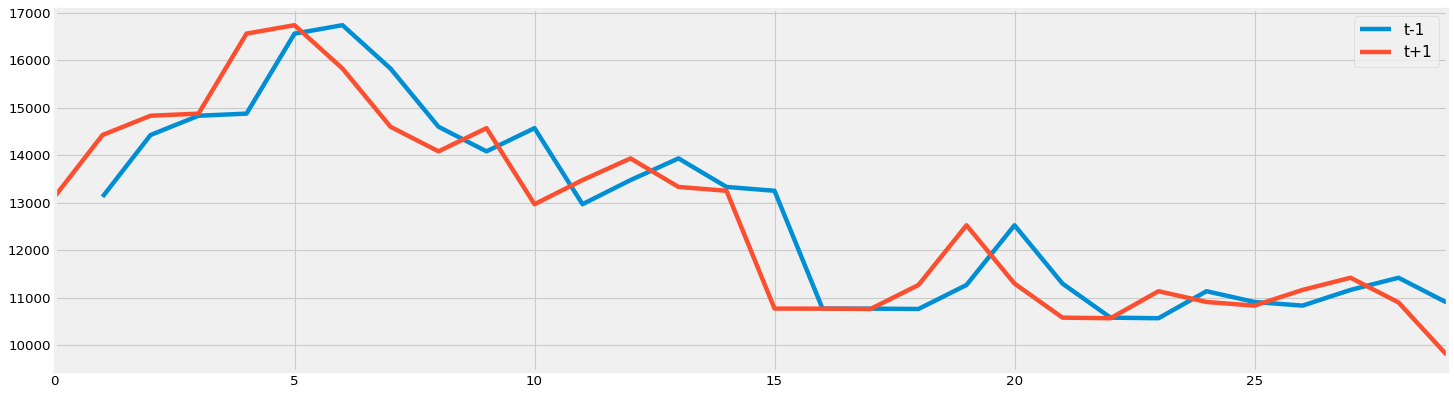

In [2]:
from sklearn.metrics import mean_squared_error
import math

# Create lagged dataset
values = pd.DataFrame(btc['price_close'].values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t-1', 't+1']

display(df.head())

### =============================== Splitting data into train and test sets ================================ ###

X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
trainX, trainY = train[:,0], train[:,1]
testX, testY = test[:,0], test[:,1]

# walk-forward validation
predictions = []
for x in testX:
    yhat = x
    predictions.append(yhat)
test_score = mean_squared_error(testY, predictions)
print('Test MSE: %.3f' % test_score)
print(math.sqrt(test_score))


figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('fivethirtyeight')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
ax = plt.gca()
df.head(30).plot(kind='line',ax=ax)

plt.show()


These are the numbers we want our better models to surpass at least. 


# 2 ) Multi Layer Perceptron Model

In [3]:
import scipy
import numpy
import matplotlib
import statsmodels
import sklearn
import theano
import tensorflow
import keras

from keras.models import Sequential
from keras.layers import Dense
numpy.random.seed(7)

Using TensorFlow backend.


In [4]:
# split into train and test sets

train_size = int(len(btc) * 0.66)
test_size = int(len(btc) - train_size)
train, test = btc[0:train_size], btc[train_size:-1]

display(train.tail(), test.head())

,date,price_close
268,2018-09-26,6311.004586
269,2018-09-27,6599.216414
270,2018-09-28,6549.040445
271,2018-09-29,6534.189410
272,2018-09-30,6563.363297


,date,price_close
273,2018-10-01,6491.209178
274,2018-10-02,6447.271634
275,2018-10-03,6402.601071
276,2018-10-04,6484.769153
277,2018-10-05,6499.968281


In [5]:
def create_dataset(dataset, lookback=1):
    dataset = dataset.reset_index()
    dataX, dataY = [], []
    for i in range(len(dataset)-1):
        dataX.append(dataset['price_close'][i])
        dataY.append(dataset['price_close'][i+lookback])
    numpy.array(dataX), numpy.array(dataY)
    return dataX, dataY

trainX, trainY = create_dataset(train)
testX, testY = create_dataset(test)


In [6]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(5, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

import math
# estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 0s - loss: 44055333.4890
Epoch 2/50
 - 0s - loss: 7772026.3929
Epoch 3/50
 - 0s - loss: 386789.7524
Epoch 4/50
 - 0s - loss: 190771.5773
Epoch 5/50
 - 0s - loss: 193941.4001
Epoch 6/50
 - 0s - loss: 193225.1043
Epoch 7/50
 - 0s - loss: 193658.3048
Epoch 8/50
 - 0s - loss: 194178.4229
Epoch 9/50
 - 0s - loss: 192642.5710
Epoch 10/50
 - 0s - loss: 194476.3122
Epoch 11/50
 - 0s - loss: 194525.7738
Epoch 12/50
 - 0s - loss: 198686.8673
Epoch 13/50
 - 0s - loss: 197000.6295
Epoch 14/50
 - 0s - loss: 196996.4490
Epoch 15/50
 - 0s - loss: 199367.8792
Epoch 16/50
 - 0s - loss: 195010.6126
Epoch 17/50
 - 0s - loss: 194256.6807
Epoch 18/50
 - 0s - loss: 197688.5113
Epoch 19/50
 - 0s - loss: 193563.4873
Epoch 20/50
 - 0s - loss: 204966.2274
Epoch 21/50
 - 0s - loss: 195561.7465
Epoch 22/50
 - 0s - loss: 194795.0135
Epoch 23/50
 - 0s - loss: 195146.0088
Epoch 24/50


Train Score: 189573.90 MSE (435.40 RMSE)
Test Score: 25778.57 MSE (160.56 RMSE)


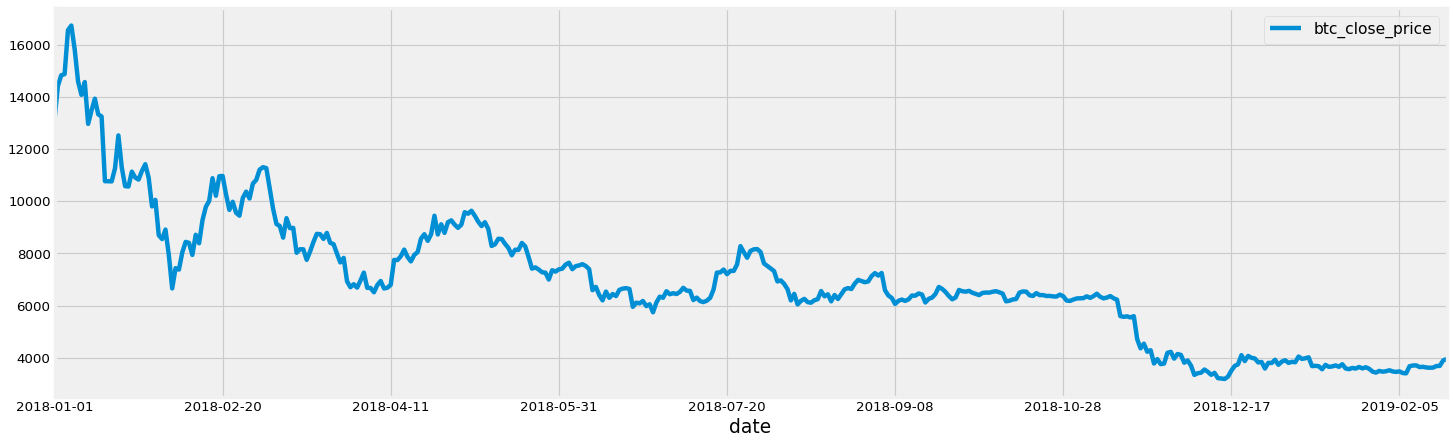

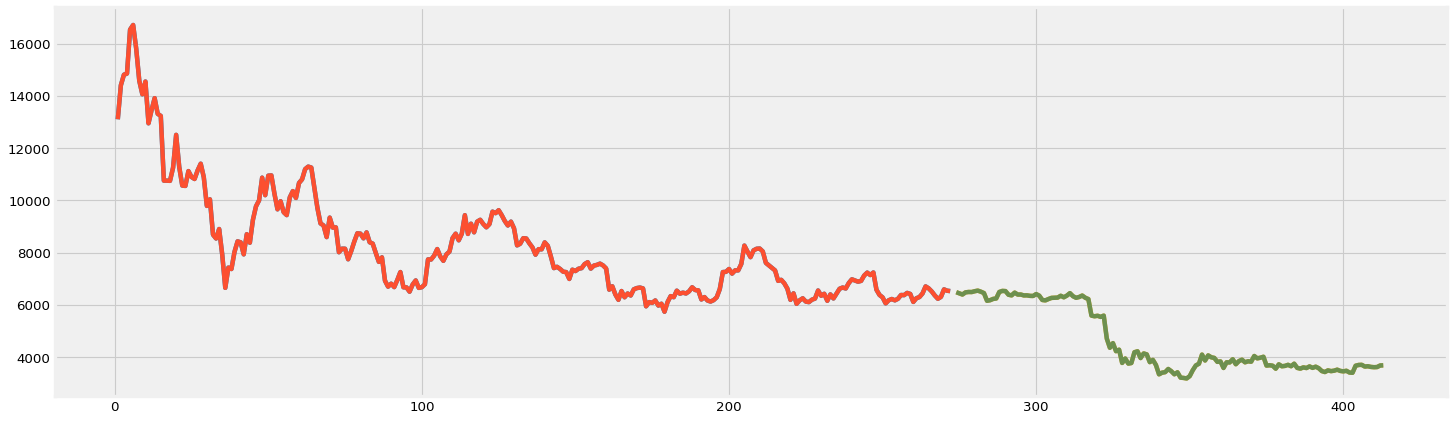

In [7]:
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

dataset = btc
lookback = 1
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[lookback:len(trainPredict)+lookback, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(lookback*1)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions

one_df_many_grans(btc, [len(btc)]) 

figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()



##  Epochs < 100 might be better for this model

With 200 Epochs, the test set had a MSE of 198.

With 50 Epochs, we got a MSE of 160, about the same as persistance model. 
 
## Next we are trying a Long Short-Term Memory model

In [8]:
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np

min_max_scaler = MinMaxScaler()
btc = btc.drop(columns=['date'])
df = btc
prediction_days = len(btc) - train_size
df_train= df[:len(df)-prediction_days]
df_test= df[len(df)-prediction_days:]


training_set = df_train.values
training_set = min_max_scaler.fit_transform(training_set)

x_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
x_train = np.reshape(x_train, (len(x_train), 1, 1))


In [15]:
num_units = 4
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 5
num_epochs = 200

# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = num_units, activation = activation_function, input_shape=(None, 1)))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = optimizer, loss = loss_function)

# Using the training set to train the model
regressor.fit(x_train, y_train, batch_size = batch_size, epochs = num_epochs)


Epoch 1/200
272/272 [==============================] - 1s 4ms/step - loss: 0.0441
Epoch 2/200
272/272 [==============================] - 0s 1ms/step - loss: 0.0387
Epoch 3/200
272/272 [==============================] - 0s 862us/step - loss: 0.0379
Epoch 4/200
272/272 [==============================] - 0s 737us/step - loss: 0.0372
Epoch 5/200
272/272 [==============================] - 0s 708us/step - loss: 0.0367
Epoch 6/200
272/272 [==============================] - 0s 766us/step - loss: 0.0362
Epoch 7/200
272/272 [==============================] - 0s 745us/step - loss: 0.0355
Epoch 8/200
272/272 [==============================] - 0s 722us/step - loss: 0.0349
Epoch 9/200
272/272 [==============================] - 0s 838us/step - loss: 0.0344
Epoch 10/200
272/272 [==============================] - 0s 796us/step - loss: 0.0339
Epoch 11/200
272/272 [==============================] - 0s 740us/step - loss: 0.0332
Epoch 12/200
272/272 [==============================] - 0s 709us/step - loss: 

272/272 [==============================] - 0s 939us/step - loss: 0.0015
Epoch 193/200
272/272 [==============================] - 0s 696us/step - loss: 0.0016
Epoch 194/200
272/272 [==============================] - 0s 715us/step - loss: 0.0016
Epoch 195/200
272/272 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 196/200
272/272 [==============================] - 0s 838us/step - loss: 0.0016
Epoch 197/200
272/272 [==============================] - 0s 875us/step - loss: 0.0016
Epoch 198/200
272/272 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 199/200
272/272 [==============================] - 0s 767us/step - loss: 0.0015
Epoch 200/200
272/272 [==============================] - 0s 997us/step - loss: 0.0016


In [16]:
test_set = df_test.values

inputs = np.reshape(test_set, (len(test_set), 1))
inputs = min_max_scaler.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))

predicted_price = regressor.predict(inputs)
predicted_price = min_max_scaler.inverse_transform(predicted_price)

error = mean_squared_error(test_set, predicted_price)
print('Test MSE: %.3f' % error)
print(math.sqrt(error))


Test MSE: 12295.392
110.88459086758871


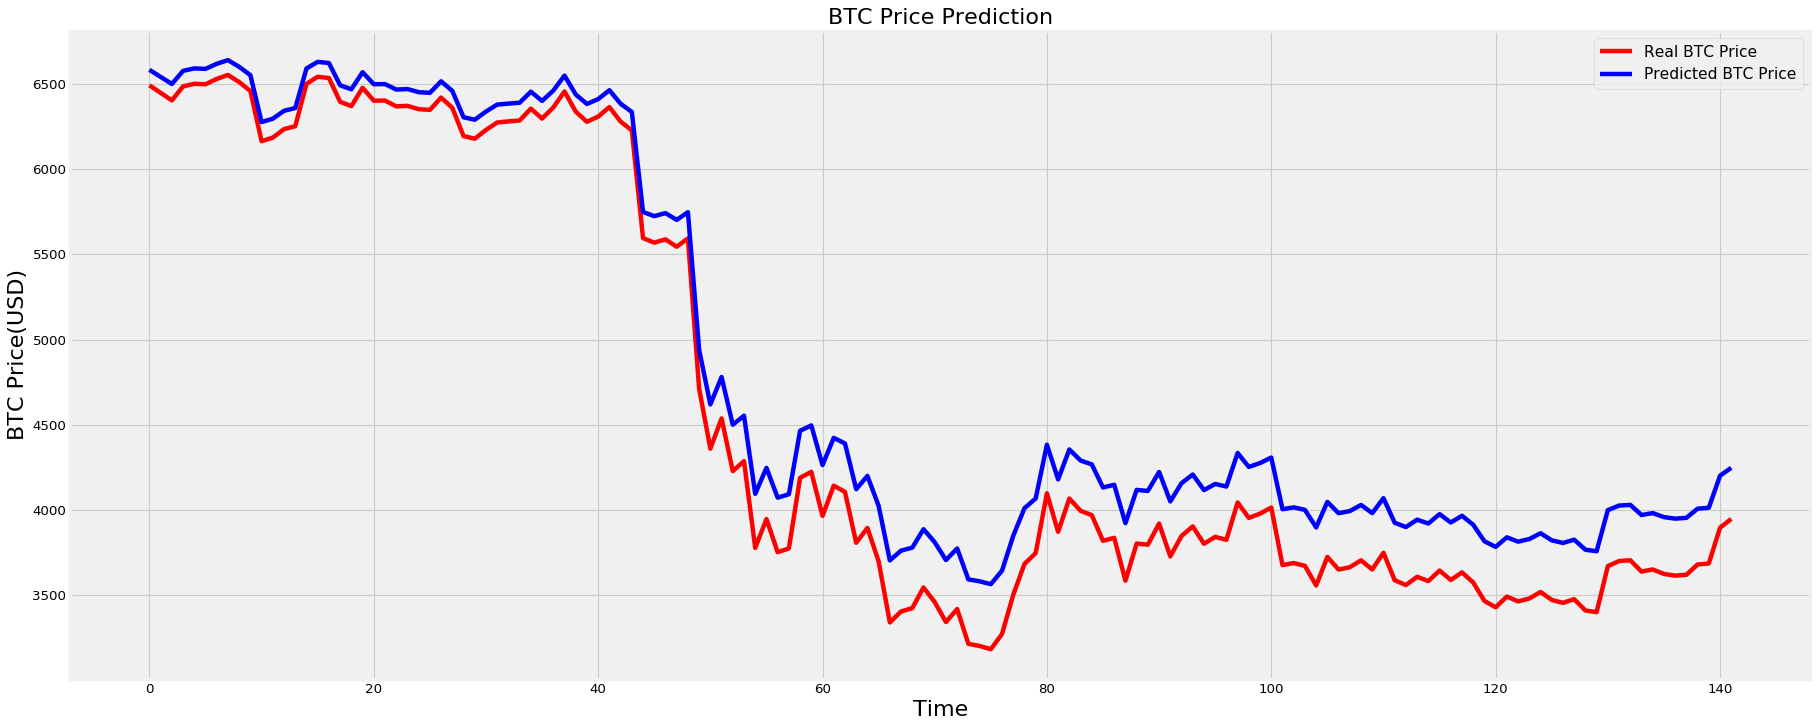

In [11]:
plt.figure(figsize=(25, 10), dpi=80, facecolor = 'w', edgecolor = 'k')

plt.plot(test_set[:, 0], color='red', label='Real BTC Price')
plt.plot(predicted_price[:, 0], color = 'blue', label = 'Predicted BTC Price')

plt.title('BTC Price Prediction', fontsize = 20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('BTC Price(USD)', fontsize = 20)
plt.legend(loc = 'best')
plt.show()

## AIRMA model

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:          D.price_close   No. Observations:                  414
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3026.936
Method:                       css-mle   S.D. of innovations            362.278
Date:                Mon, 10 Jun 2019   AIC                           6067.872
Time:                        05:51:59   BIC                           6096.053
Sample:                             1   HQIC                          6079.017
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -22.3011     17.880     -1.247      0.213     -57.344      12.742
ar.L1.D.price_close    -0.0133      0.050     -0.267      0.789      -0.111       0.084
ar.L2.D.price_cl

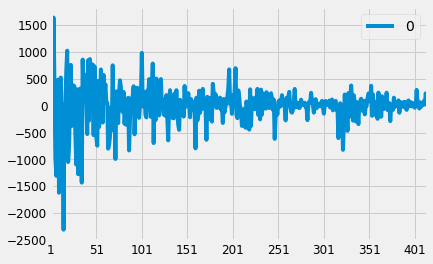

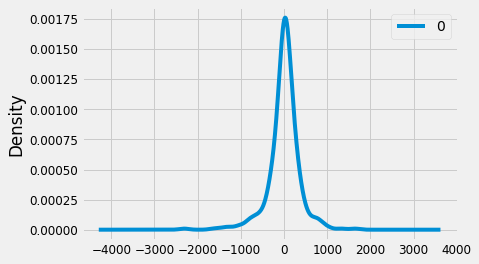

                 0
count   414.000000
mean      0.200973
std     362.978245
min   -2311.919280
25%    -109.008892
50%      18.913977
75%     148.655239
max    1642.198047


In [12]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# fit model
model = ARIMA(btc, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [13]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
series = btc
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)


predicted=6508.313507, expected=6491.209178
predicted=6487.926097, expected=6447.271634
predicted=6421.301621, expected=6402.601071
predicted=6370.476771, expected=6484.769153
predicted=6466.137108, expected=6499.968281
predicted=6476.306143, expected=6497.284547
predicted=6478.713093, expected=6528.837220
predicted=6493.350206, expected=6551.964546
predicted=6530.853530, expected=6510.163119
predicted=6489.170218, expected=6457.685456
predicted=6430.364376, expected=6163.191080
predicted=6137.594404, expected=6184.381134
predicted=6156.955397, expected=6234.027446
predicted=6202.027658, expected=6251.483295
predicted=6257.990439, expected=6499.749472
predicted=6457.620449, expected=6541.164156
predicted=6518.550042, expected=6533.816795
predicted=6520.921041, expected=6394.431994
predicted=6346.506260, expected=6369.287384
predicted=6350.865727, expected=6476.456709
predicted=6449.493883, expected=6400.960371
predicted=6394.490948, expected=6401.818128
predicted=6376.004926, expected=

Test MSE: 24874.277
157.7158098627202


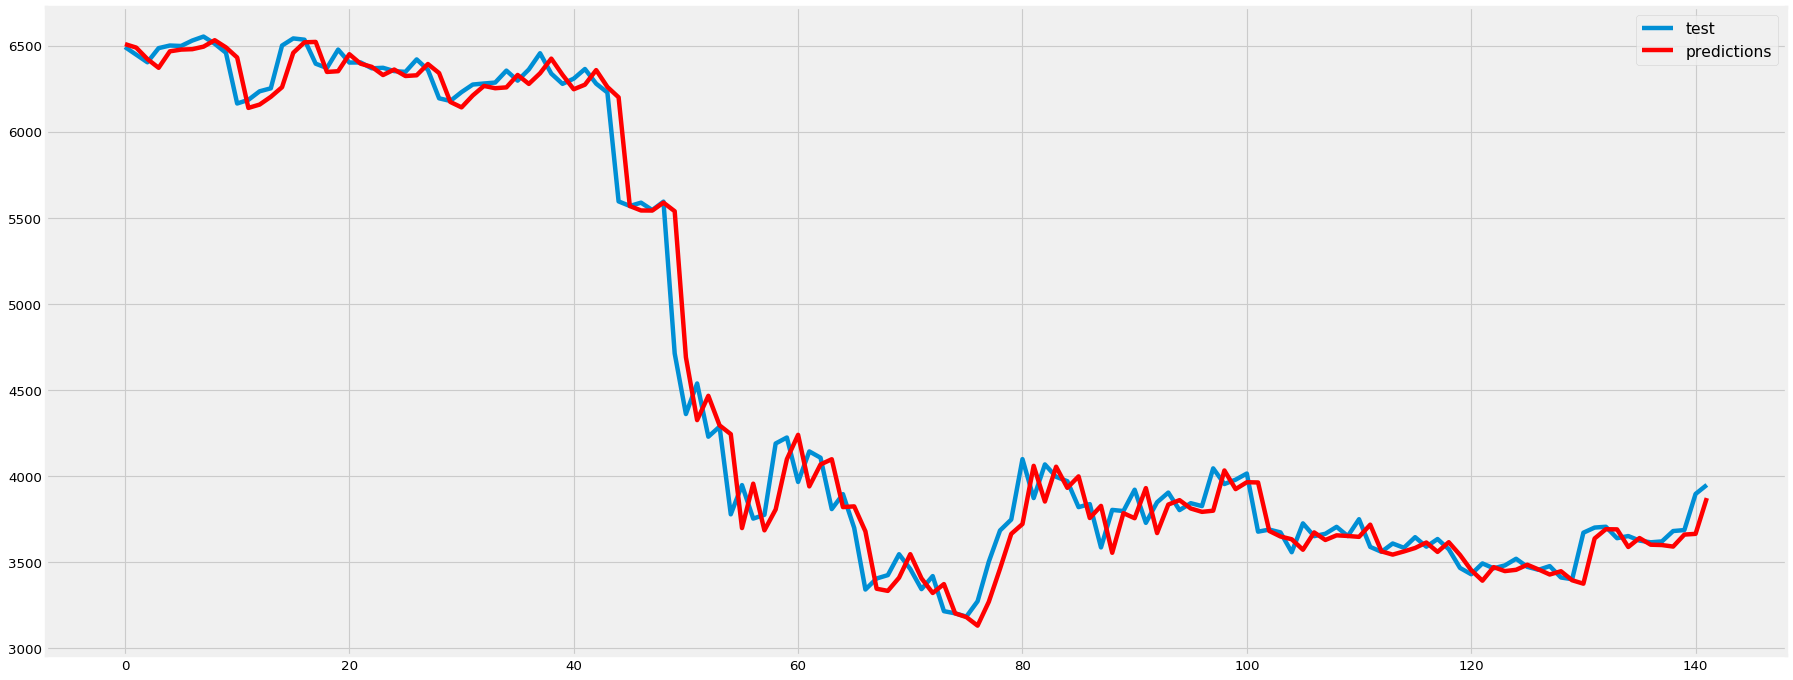

In [14]:
print('Test MSE: %.3f' % error)
print(math.sqrt(error))
# plot
plt.figure(figsize=(25, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(test, label='test')
plt.plot(predictions, color='red', label='predictions')
plt.legend(loc = 'best')
plt.show()

## Winning model is LSTM with a ME of about 110

Let's try a multivariate LSTM model. We'll use price close, volume_total, and a sentiment indicator. 
